In [1]:
using LinearAlgebra
using Plots
using RefractiveIndex, Unitful
using LaTeXStrings
using Colors


In [2]:
TiO2 = RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=TiO2&page=Devore-o")
Au=RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=Au&page=Johnson")
BK7=RefractiveMaterial("https://refractiveindex.info/?shelf=glass&book=BK7-Schott&page=Lane")
Cr=RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=Cr&page=Johnson")

Cr (Johnson and Christy 1974: n,k 0.188–1.937 µm) - TabulatedNK

In [3]:
function n_m(m,λ) #λ in nm 
    dispersion(m,Float64(λ*1e-3))
end


n_m (generic function with 1 method)

In [46]:
# -------------------------------
# Refractive indices
# -------------------------------
nTiO2 = n_m.(Ref(TiO2),lambda) ###May be differnet from constant value
n0 = fill(nsub, length(lam))
nglass = fill(nsup+0im, length(lam))
nCr = n_m.(Ref(Cr),lambda) 
nend = fill(nsup, length(lam))
noil=fill(noil1,length(lam))


# -------------------------------
# Drude–Lorentz model for gold
# A. Vial et al.
# -------------------------------
c = 2.99792458e8                      # speed of light [m/s]
w = 2π * c ./ (lam .* 1e-9)
epsL_inf = 5.9673
wD = 2π * 2113.6e12
gD = 2π * 15.92e12
omegaL = 2π * 650.07e12
GL = 2π * 104.86e12
Deps = 1.09
#-------------------------------------
# Calculate refractive index of gold
#-------------------------------------
epsAu = ComplexF64[] #Gold ϵ
for k in eachindex(lam)
    push!(epsAu, epsL_inf - (wD^2) / (w[k] * (w[k] + 1im*gD))
          - (Deps * omegaL^2) / ((w[k]^2 - omegaL^2) + 1im*GL*w[k]))
end
nAu = sqrt.(epsAu)

# Construct refractive index matrix
#nref = transpose([n0 noil nCr nAu nend])  # (3 × Nλ) [n0 nAu nTiO2 nend]' ###
#nref= transpose([nend nglass nAu nCr n0])  # (3 × Nλ) [n0 nAu nTiO2 nend]' ###

function Timmy(lam, ang, N; k0=k0,pol=pol, dd=dd, dm=dm)
    layers=repeat([dd dm],1,Int(N/2))
    d = [layers 3] 
    z0 = 0#zeros(Float64, N+1)
    z=cumsum(d,dims=1)
    hcat(z0,z)';
    d = [layers 3] 
    nref = transpose(hcat(nend, repeat([nglass nAu],1,Int(N/2)), nCr, n0)) #Air, glass, Au, Cr, substrate
    
    # -------------------------------
    # Reflectance and Transmittance
    # -------------------------------
    Rf = zeros(length(lam), length(ang))
    Tr = zeros(length(lam), length(ang))

    for (ii, λ) in enumerate(lam) # For every Wvelength
        for (jj, θ) in enumerate(ang)####For every angle 
            T = Matrix{ComplexF64}(I, 2, 2)
            #rf = Matrix{ComplexF64}(I, 2, 2)
            b2 = k0[ii] * nsub * sin(θ)

            for kk in 1:length(z)
                aj = sqrt(k0[ii]^2 * nref[kk, ii]^2 - b2^2)
                aj1 = sqrt(k0[ii]^2 * nref[kk+1, ii]^2 - b2^2)

                if pol == 0
                    nuj, nuj1 = nref[kk, ii]^2, nref[kk+1, ii]^2
                else
                    nuj, nuj1 = 1.0, 1.0
                end

                kj = (aj * nuj1) / (aj1 * nuj)
                a11 = (1 + kj) * exp(1im * (aj - aj1) * z[kk])
                a12 = (1 - kj) * exp(-1im * (aj + aj1) * z[kk])
                a21 = (1 - kj) * exp(1im * (aj + aj1) * z[kk])
                a22 = (1 + kj) * exp(-1im * (aj - aj1) * z[kk])
                Tj = 0.5 * [a11 a12; a21 a22]
                T= Tj*T
                #println(Tj)
                #println(a11)
                #println(kk)
            end
            rf = -T[2,1] / T[2,2]
            Rf[ii, jj] = abs2(rf)
            Tr[ii, jj] = 1 - Rf[ii, jj]
            
        end
    end
    #This was run on linux 
    AngC = copy(asin(nsup/nsub) * 180/π)
    ThetaC = AngC#fill(AngC, length(lam))
    RfAux = range(0, 1, length(lam))
    return Rf, Tr, ThetaC, RfAux
end

Timmy (generic function with 1 method)

In [143]:
# -------------------------------
# Parameters
# -------------------------------
N =collect(range(2, 20, step=2))           # number of thin films (intermediate layers)
pol = 0               # polarization: 0 = TM, 1 = TE
lam_ini = 500.0       # initial wavelength [nm]
lam_fin = 830.0       # final wavelength [nm]
ang_ini = 0.0         # initial incidence angle [deg]
ang_fin = 80.0        # final incidence angle [deg]
nsub = 1.515            # substrate refractive index
noil1 = 1.512
nsup = 1.0            # superstrate refractive index
# ---------------
# Layer Parameters
# ----------------
P=0.9
dm= 10 #nm
dd= dm*(1-P)/P
T1=dm+dd

# -------------------------------
# Wavelength and angle grids
# -------------------------------
lambda=lam_ini:1.0:lam_fin
lam = ComplexF64.(lambda)  #λ
k0 = 2π ./ lam
ang_inc = ang_ini:0.1:ang_fin
ang = deg2rad.(ang_inc);


In [144]:
results = Timmy.(Ref(lam), Ref(ang), N; k0=k0, pol=pol, dd=dd, dm=dm);
#Rf, Tr, ThetaC, RfAux=Timmy.(lam, ang, Ref(N); k0=k0,pol=pol, dd=dd, dm=dm);

L, M = size(results[1][1])   # size of each matrix
K = length(N)

Rf3D     = Array{Float64}(undef, L, M, K)
Tr3D     = Array{Float64}(undef, L, M, K)
ThetaC = results[1][3]#Array{Float64}(undef, L, M, K)
RfAux3D  = Array{Float64}(undef, L, M, K)

for k in 1:K
    Rf3D[:, :, k]     .= results[k][1]
    Tr3D[:, :, k]     .= results[k][2]
    #ThetaC3D[:, :, k] .= results[k][3]
    RfAux3D[:, :, k]  .= results[k][4]
end

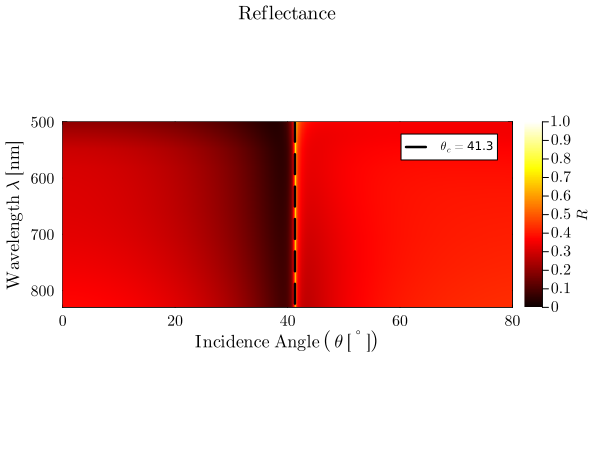

In [145]:
# --- General plotting style ---
default(
    framestyle = :box,
    legend = :topright,
    guidefont = font(12, "Computer Modern"),
    tickfont = font(10, "Computer Modern"),
    titlefont = font(13, "Computer Modern"),
    grid = false,
    size = (600, 450)
)

# --- Heatmap plot ---
p1 = heatmap(
    ang_inc,
    real.(lam),
    Rf3D[:,:,1];
    xlabel = L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)",
    ylabel = L"\mathrm{Wavelength\ }\lambda\ [\mathrm{nm}]",
    title = L"\mathrm{Reflectance}",
    colorbar_title = L"R",
    color = :hot,
    ylim = (lam_ini, lam_fin),
    xlim = (0, ang_fin),
    yflip = true,
    aspect_ratio = 0.1,          # ⟵ adjust this           # ⟵ bigger and proportioned
    clims = (0, 1),
    framestyle = :box
)

# --- Add critical angle trace ---
vline!(
    p1,
    [ThetaC],
    lw = 2.5,
    lc = :black,
    ls = :dash,
    label = L"\theta_c="*string(round(ThetaC, digits=2))
)


# --- Final adjustments ---
#annotate!(
#    0.85 * ang_fin, lam_ini + 0.05*(lam_fin - lam_ini),
#    text(L"\mathrm{TiO_2\ Interface}", 10, :white, :right)
#)

savefig("ReflectanceMap.svg")
savefig("ReflectanceMap.png")
display(p1)


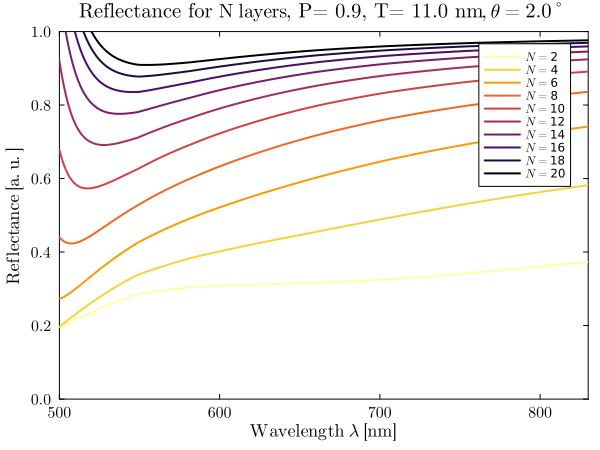

In [202]:
iθ=21  ###θ = 45 de
#colors = [:red :blue :green]
θ=ang_inc[iθ]'
colors = reverse(cgrad(:inferno))[range(0, 1, length=length(N))]

p3 = plot(
    lambda,
    Rf3D[:, iθ, :],
    lw = 2,
    label = L"N= " .* string.(N'),
    color = permutedims(colors),  # Reshape to match line orientation
    xlims = (lam_ini, lam_fin),
    ylims = (0, 1),
    title = "Reflectance for " * L"\mathrm{N\ layers}" * ", P= " * string(P) * ", T= " * string(round(T1)) * " nm" * L",\theta= " * string(ang_inc[iθ]) * L"^\circ",
    ylabel = L"\mathrm{Reflectance\ [a.u.]}",
    xlabel = L"\mathrm{Wavelength \ \lambda\ [nm]}",
)
#plot!(lambda, Tr[:, iθ], lw=3, label=L"\mathrm{Transmission}", color=:blue,xlims=(lam_ini, lam_fin),ylims=(0,1))
###-------------

#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)

#plot!(legend=:topright, title="Reflectance") 
#annotate!(680, 0.8,text(L"\theta=45^\circ", 15, :black, :right))

savefig("Reflectancevslambda.svg")
savefig("Reflectancevslambda.png")
display(p3)

In [178]:
N./maximum(N)

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [251]:
Rfconstant=Rf;
Trconstant=Tr;

In [252]:
RF=transpose(Rf)
Θ1= repeat(ang_inc, 1, length(lam));
n=700-380 #number of colors
colors = cgrad(:turbo, n, categorical=true)

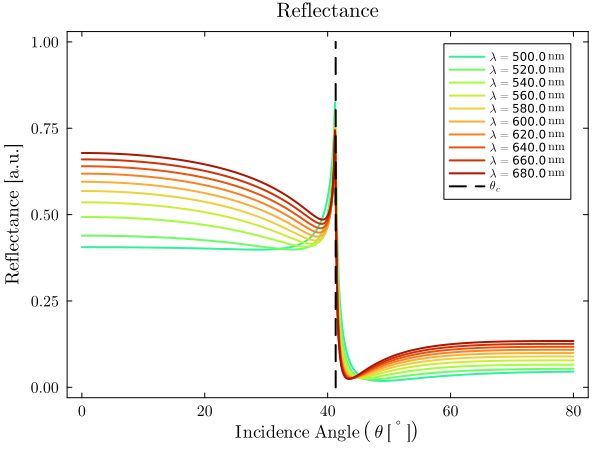

In [253]:
# Create a discrete color palette with n colors
Δλ =20
sθ =2
# Now plot using integer indices
pp = plot(legend=true)
for i in 1:Δλ:200#length(lam) up to 700 nm
    plot!(pp, Θ1[1:sθ:end, i], RF[1:sθ:end, i], 
          color = colors[Int.(lam[i])-380],  # Direct integer indexing
          lw = 2,label = L"\lambda = "* string(real(lam[i])) * L"\ \mathrm{nm}"
)
end
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label=L"\theta_c")
savefig("Reflectancevslambda.svg")
xlabel!(L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)")
ylabel!("Reflectance [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Reflectance")
savefig("Reflectance_lambdas_vsangle.svg")
savefig("Reflectance_lambdas_vsangle.png")
display(pp)

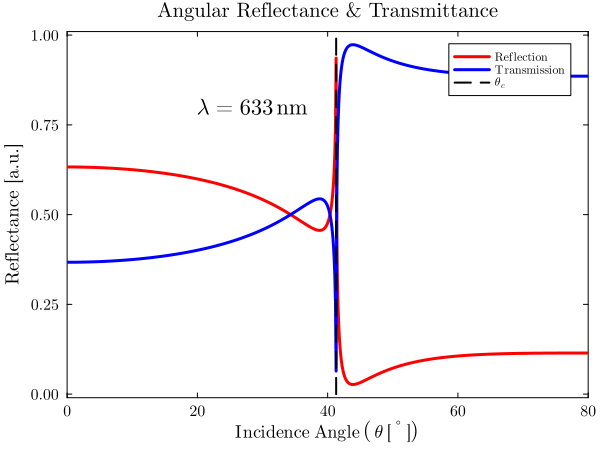

In [254]:
# Reflectance and Transmittance at specific λ
Nlam = 134 ###λ = 633 nm
p2 = plot(ang_inc, Rf[Nlam, :], lw=3, label=L"\mathrm{Reflection}", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
#plot!(ang_inc, Rf[165, :], lw=3, label=L"\mathrm{Reflection 165}", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Tr[Nlam, :], lw=3, label=L"\mathrm{Transmission}", color=:blue)
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label=L"\theta_c")
xlabel!(L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)")
ylabel!("Reflectance [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Angular Reflectance & Transmittance")
annotate!(37, 0.8, 
    text(L"\lambda = 633\,\mathrm{nm}", 15, :black, :right)
)
savefig("Reflectancevsangle.svg")
savefig("Reflectancevsangle.png")
display(p2)

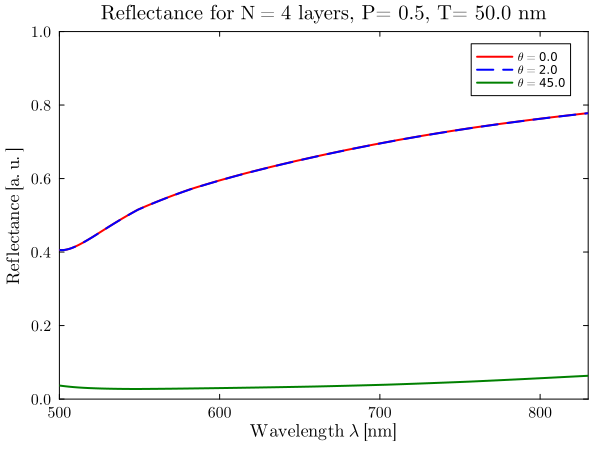

In [279]:
iθ=[1, 21, 451]  ###θ = 45 de
a=2
colors = [:red :blue :green]
θ=ang_inc[iθ]'
p3 = plot(
    lambda,
    Rf[:, iθ],
    lw = 2,
    label =L"\theta= ".*string.(θ),          # convert θ values to strings
    color = colors,
    xlims = (lam_ini, lam_fin),
    ylims = (0, 1),
    linestyle = [:solid :dash :solid],
    title="Reflectance for "*L"\mathrm{N= }"*string(N)*" layers"*", P= "*string(P)*", T= "*string(T1)*" nm",
    ylabel=L"\mathrm{Reflectance\ [a.u.]}",
    xlabel=L"\mathrm{Wavelength \ \lambda\ [nm]}",
)
#plot!(lambda, Tr[:, iθ], lw=3, label=L"\mathrm{Transmission}", color=:blue,xlims=(lam_ini, lam_fin),ylims=(0,1))
###-------------

#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)

#plot!(legend=:topright, title="Reflectance") 
#annotate!(680, 0.8,text(L"\theta=45^\circ", 15, :black, :right))

savefig("Reflectancevslambda.svg")
savefig("Reflectancevslambda.png")
display(p3)


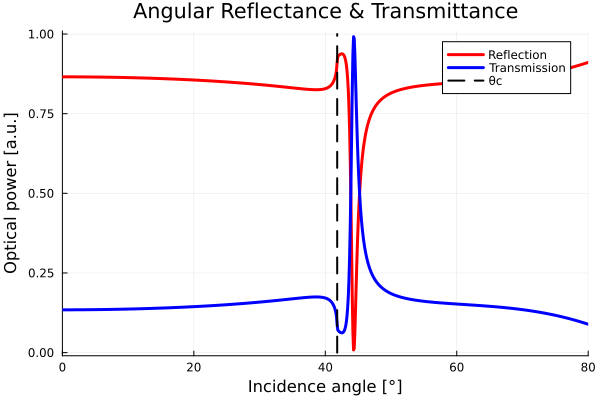

In [74]:
# Reflectance and Transmittance at specific λ
Nlam = 134
p2 = plot(ang_inc, Rfconstant[Nlam, :], lw=3, label="Reflection", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Trconstant[Nlam, :], lw=3, label="Transmission", color=:blue)
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label="θc")
xlabel!("Incidence angle [°]")
ylabel!("Optical power [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Angular Reflectance & Transmittance")

#display(p1)
#display(p2)

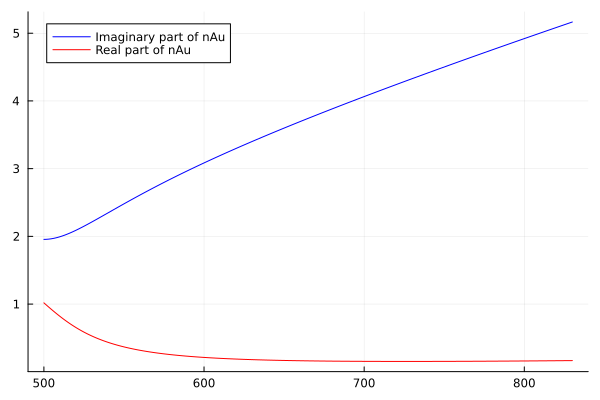

In [35]:
plot(real(lam),imag(nAu),color=:blue, label="Imaginary part of nAu")
plot!(real(lam),real(nAu),color=:red, label="Real part of nAu")